In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial
import xarray as xr

import SeaLevelContrib as slc

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
max_depth = 400
start_year = 1960

In [3]:
def thickness_from_depth(depth):
    '''Define a thickness Data Array from depth coordinate'''
    midp = (np.array(depth[1:])+np.array(depth[:-1]))/2
    midp = np.insert(midp, 0, np.array([0]))
    midp = np.insert(midp, len(midp), np.array(depth[-1]) + 
                     (np.array(depth[-1]) - np.array(depth[-2])))
    thick = midp[1:] - midp[:-1]
    thick_da = xr.DataArray(thick, coords={'depth': depth[:]}, dims='depth')
    return thick_da

def StericSL2(data_source, min_depth, max_depth, window):
    '''Compute the steric sea level in cm integrated between two depth levels 
    given in meters. '''
    
    if data_source == 'IAP':
        density_ds = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')
    elif data_source == 'EN4_22':
        density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
    else:
        print('ERROR: data_source not defined')
    
    thick_da = thickness_from_depth(density_ds.depth)
    SumDens = density_ds.density * thick_da
    
    rho_0 = density_ds.density[0 ,0 ,: ,:];
    
    StericSL = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / rho_0) * 100
    StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
    StericSL.name = 'Steric'
    
    if window > 1:
        frac = window/StericSL_df.shape[0]
        StericSL_df['Steric'] = lowess(StericSL_df['Steric'], StericSL_df.index, 
                                       frac, return_sorted=False)
    
    return StericSL

In [4]:
df = xr.open_mfdataset(f'/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/EN4_profiles/EN.4.2.2.analyses.g10.*/EN.4.2.2.f.analysis.g10.*.nc')

df.coords['lon'] = (df.coords['lon'] + 180) % 360 - 180
df = df.sortby(df.lon)

min_lon = -20
min_lat = 30 
max_lon = 20 
max_lat = 71

ds = df.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

temp = ds.temperature
sal = ds.salinity
t = ds.time

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/anaconda3/lib/python3.9/site-packag

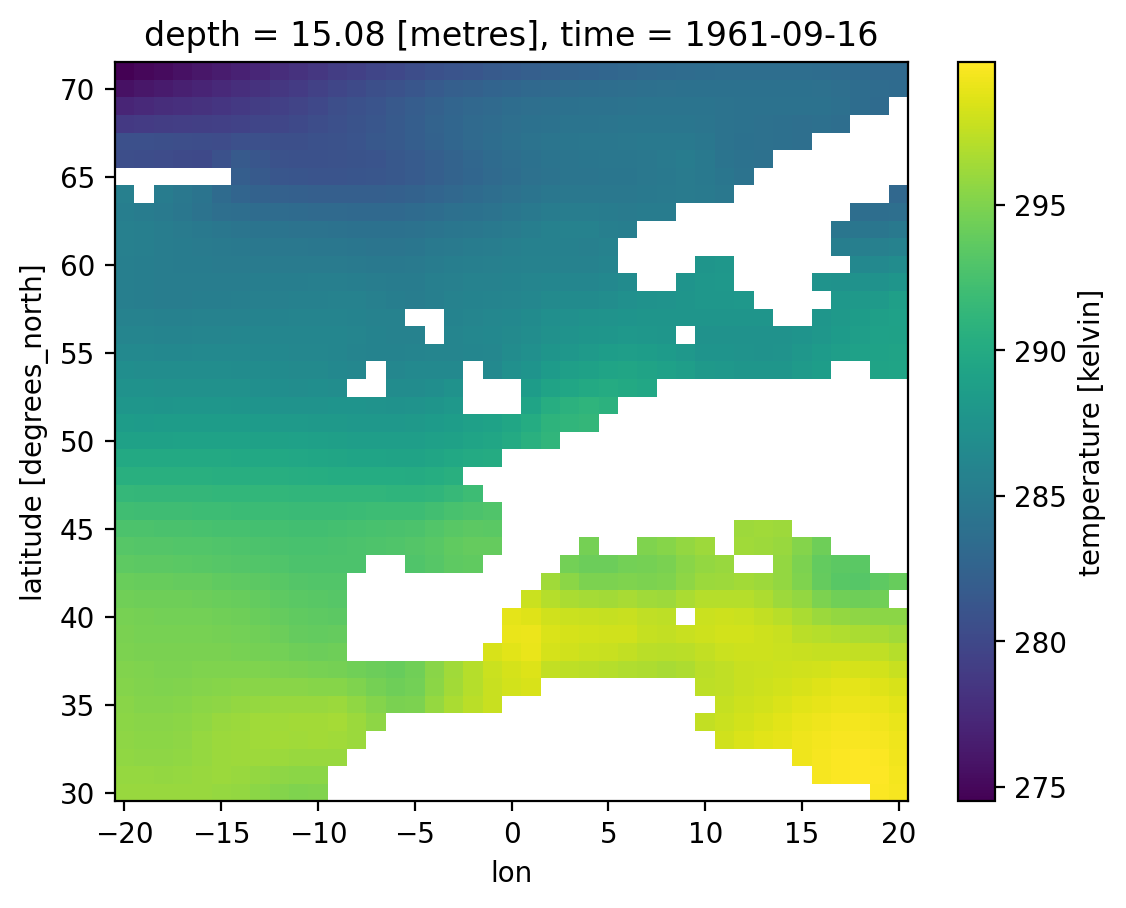

In [5]:
temp[20,1,:,:].plot();

In [10]:
print(df)

<xarray.Dataset>
Dimensions:                          (depth: 42, lat: 173, lon: 360, time: 759, bnds: 2)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 -180.0 -179.0 ... 178.0 179.0
  * time                             (time) datetime64[ns] 1960-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    tem

<xarray.DataArray 'temperature' (time: 64, depth: 42, lat: 42, lon: 41)>
dask.array<stack, shape=(64, 42, 42, 41), dtype=float32, chunksize=(1, 42, 42, 41), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 67.0 68.0 69.0 70.0 71.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2019 2020 2021 2022 2023


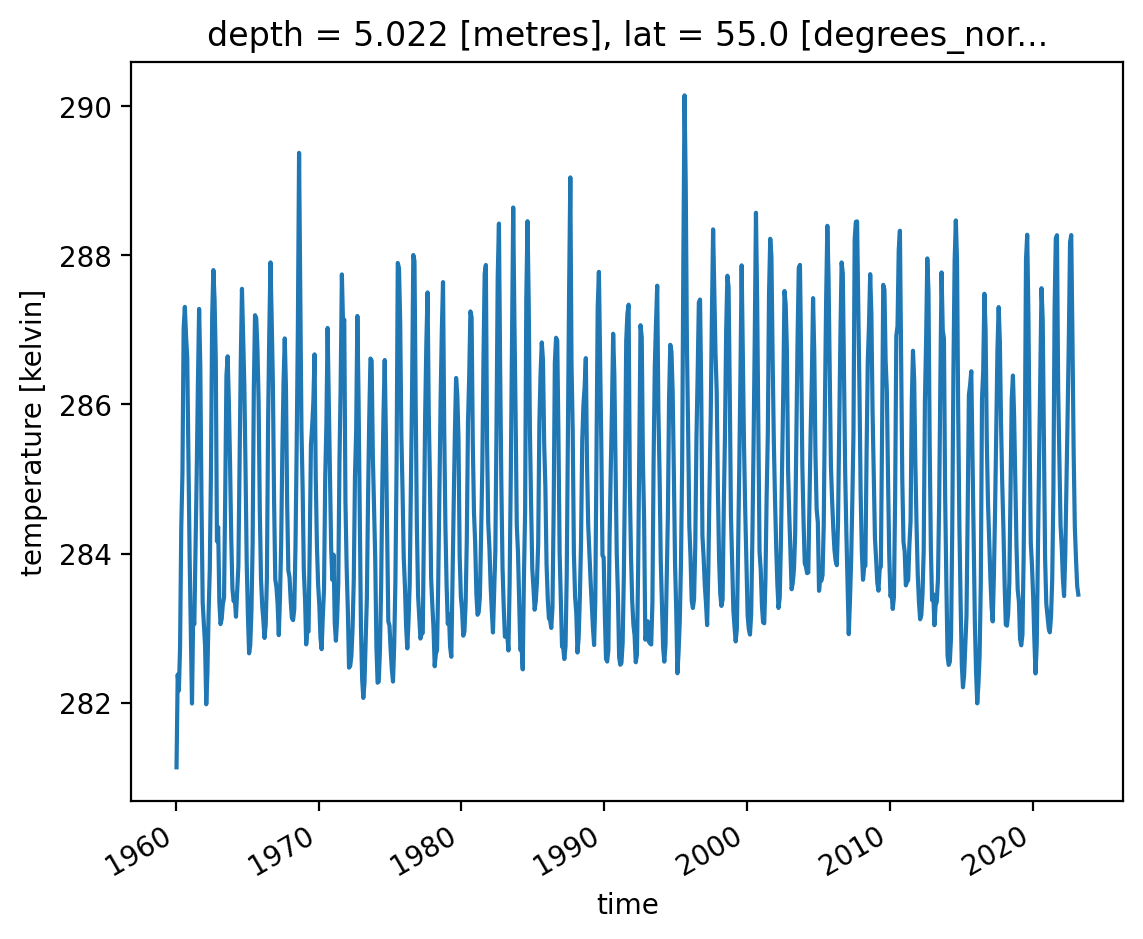

In [6]:
mean_temp = temp.groupby('time.year').mean('time')
mean_sal = sal.groupby('time.year').mean('time')

mean_temp = mean_temp.rename({'year':'time'})
mean_sal = mean_sal.rename({'year':'time'})

temp[:,0,25,1].plot();

print(mean_temp)

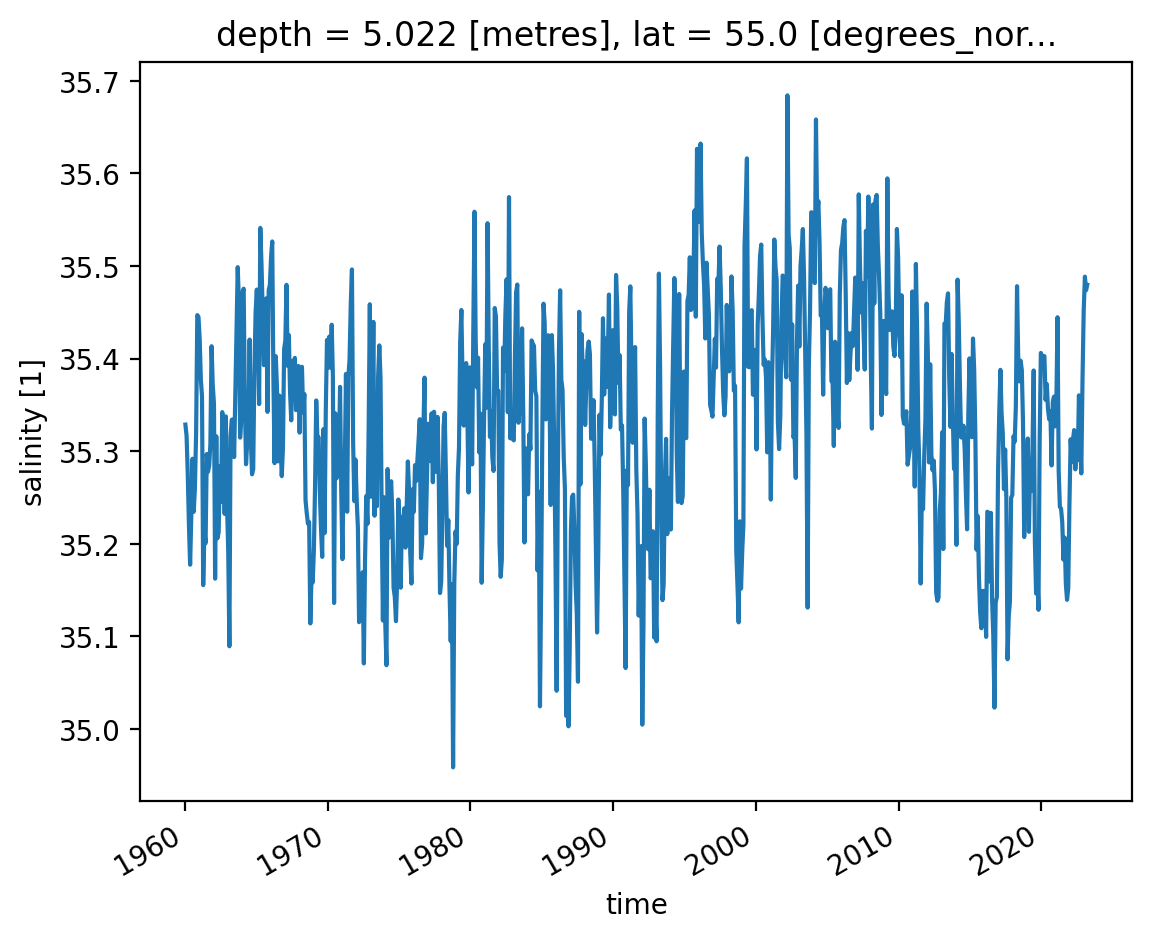

In [7]:
sal[:,0,25,1].plot();

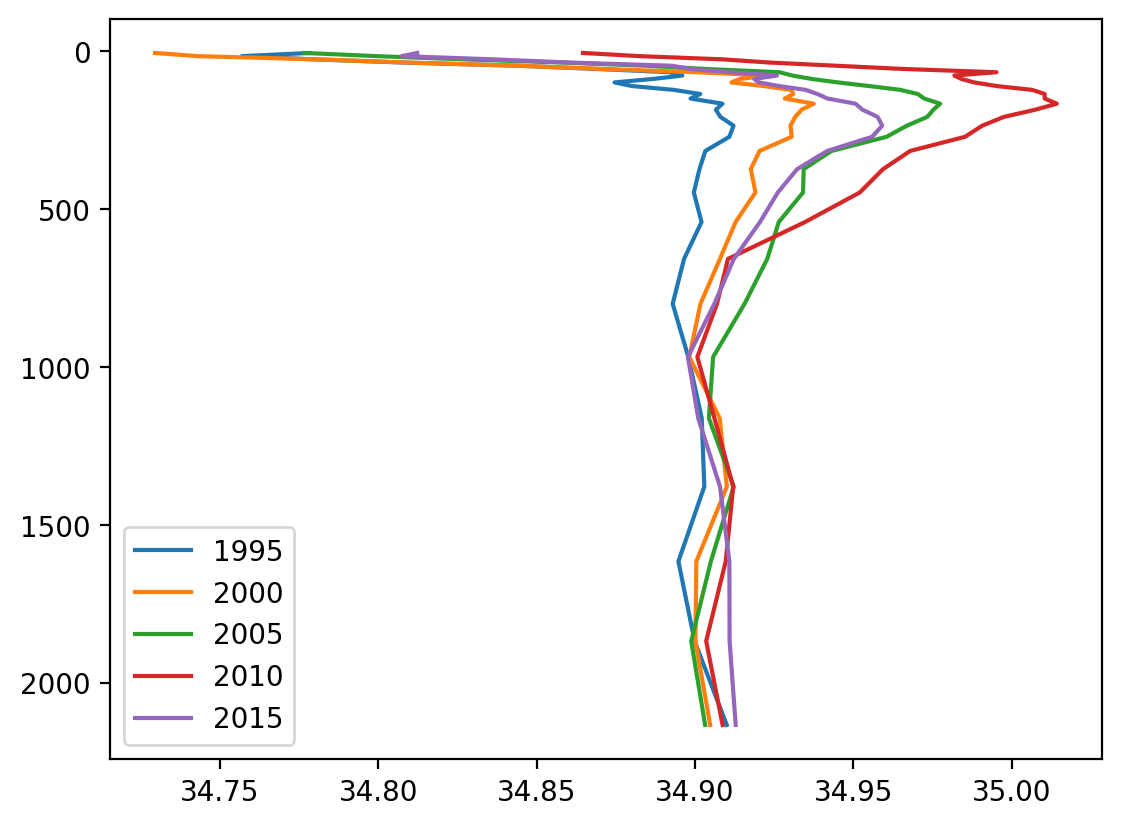

In [8]:
plt.plot(mean_sal[35,:,35,10],temp.depth,label=int(mean_sal[35,:,35,10].time))
plt.plot(mean_sal[40,:,35,10],temp.depth,label=int(mean_sal[40,:,35,10].time))
plt.plot(mean_sal[45,:,35,10],temp.depth,label=int(mean_sal[45,:,35,10].time))
plt.plot(mean_sal[50,:,35,10],temp.depth,label=int(mean_sal[50,:,35,10].time))
plt.plot(mean_sal[55,:,35,10],temp.depth,label=int(mean_sal[55,:,35,10].time))
plt.legend()
plt.gca().invert_yaxis();

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/profiles_EN4_salinity_1location.pdf', dpi=150)

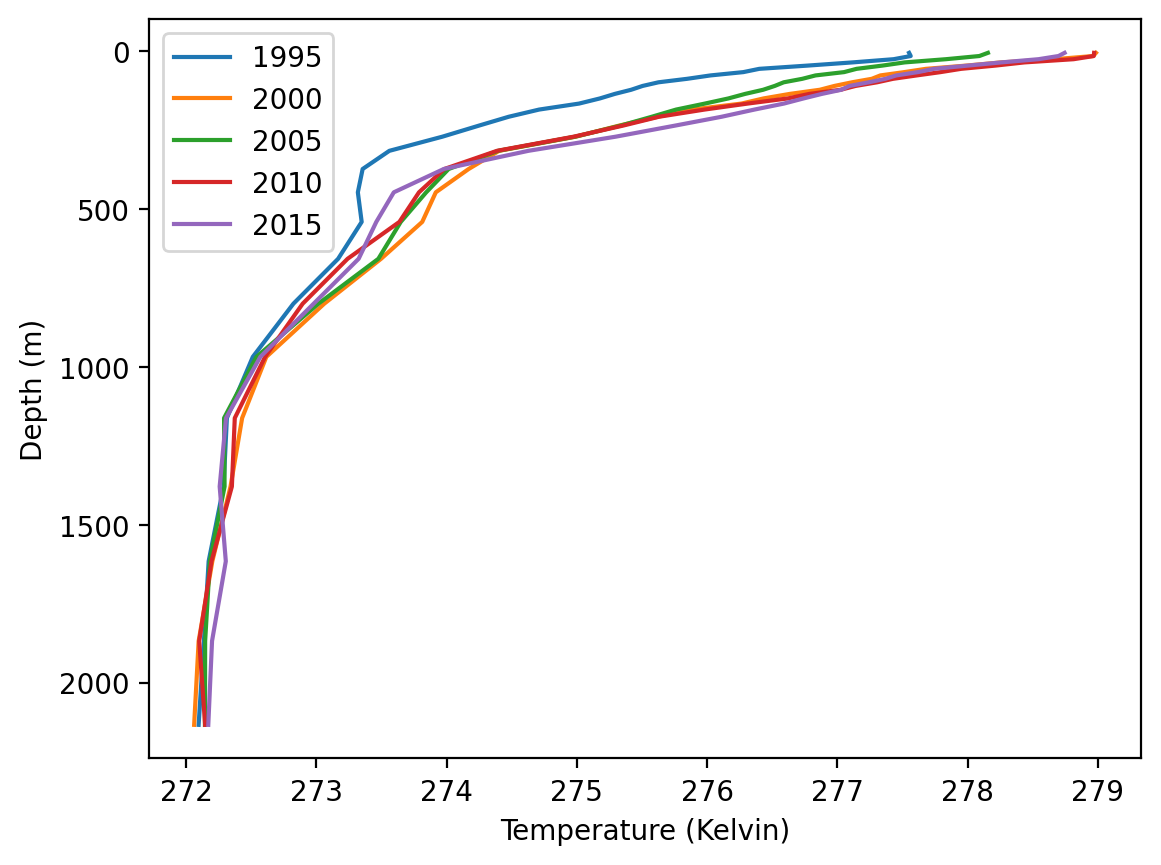

In [87]:
plt.plot(mean_temp[35,:,35,10],temp.depth,label=int(mean_temp[35,:,35,10].time))
plt.plot(mean_temp[40,:,35,10],temp.depth,label=int(mean_temp[40,:,35,10].time))
plt.plot(mean_temp[45,:,35,10],temp.depth,label=int(mean_temp[45,:,35,10].time))
plt.plot(mean_temp[50,:,35,10],temp.depth,label=int(mean_temp[50,:,35,10].time))
plt.plot(mean_temp[55,:,35,10],temp.depth,label=int(mean_temp[55,:,35,10].time))
plt.legend()
plt.gca().invert_yaxis();
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Depth (m)');

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/profiles_EN4_temperature_1location.pdf', dpi=150)

In [11]:
gam_df = len(t)//2
gam_alpha = 5000

In [12]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

def store_results_df(reg_df, res_gam, reg_list):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['nodal_steric'] = model_results_df['nod1'] + model_results_df['nod2']

    return model_results_df

def compute_model(reg_df):
    
    reg_list = ['nod1', 'nod2']
    regression_formula = 'Steric ~ nod1 + nod2'
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list)
    
    return model_results_df, res_gam

In [18]:
mask = slc.steric_masks_north_sea(mean_temp, 'EBB')
SumTemp = (mean_temp * mask).mean(dim=['lat', 'lon'])

sumtemp2 = SumTemp[:,0:26]
t = sumtemp2.time
print(t)

nodal = np.zeros((len(t),26))

for i in range(26):
    reg_df = sumtemp2[:,i].to_dataframe()
    del reg_df['depth']

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    #del reg_df['lat']
    #del reg_df['lon']
    
    reg_df.columns = ['Steric','nod1','nod2']

    res_nr, res_full_nr = compute_model(reg_df)

    res_nr['total'] = res_nr['total'] - res_nr['trend']
    nodal[:,i] = res_nr['total']

reg_df = mean_sal[:,0,25,1].to_dataframe()
t = np.linspace(1960,2023,64)

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

del reg_df['depth']
del reg_df['lat']
del reg_df['lon']

reg_df.columns = ['Steric','nod1','nod2']

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


<xarray.DataArray 'time' (time: 64)>
array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023])
Coordinates:
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2019 2020 2021 2022 2023


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: d

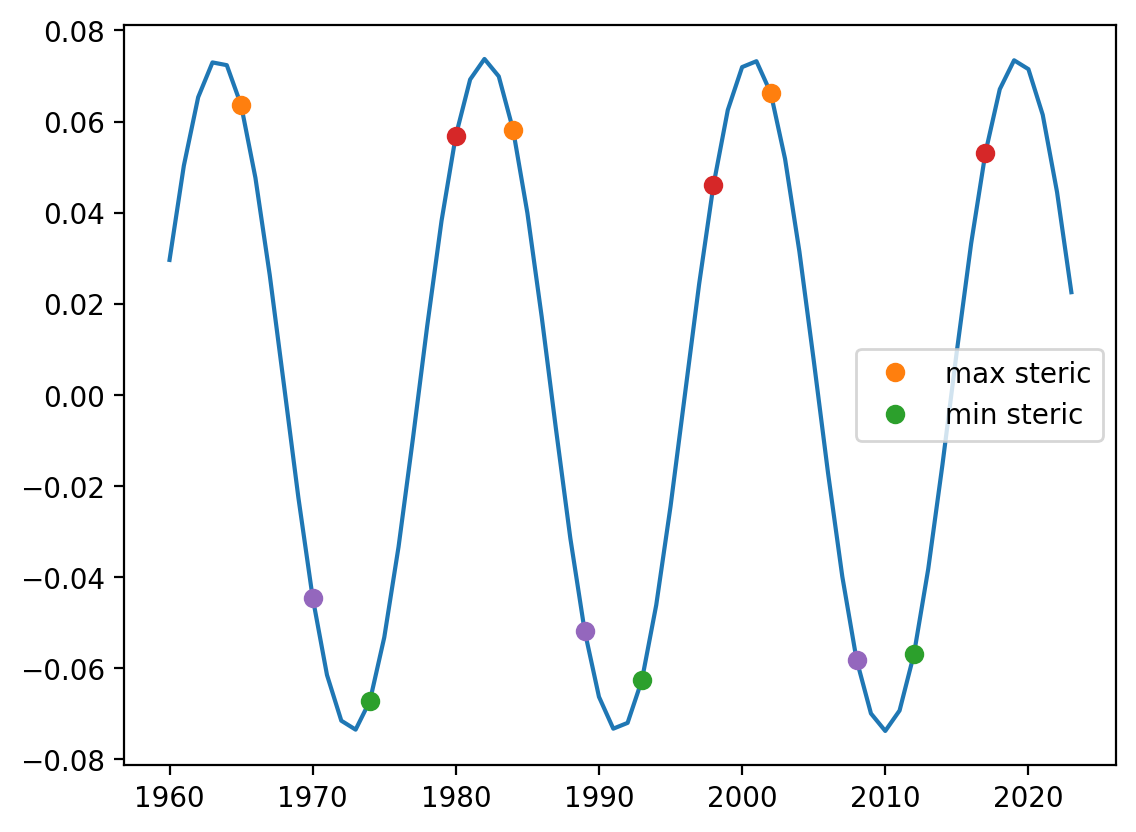

In [19]:
import scipy as sc

steric = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/nodal_steric.csv',index_col=0)
steric = steric.loc[1960:2020]

prof = np.zeros((4,26))

for i in range(26):
    der = steric.diff()

    peaks, _ = sc.signal.find_peaks(steric.values.flatten())
    troughs, _ = sc.signal.find_peaks(-steric.values.flatten())
    diff_max, _ = sc.signal.find_peaks(der.values.flatten())
    diff_min, _ = sc.signal.find_peaks(-der.values.flatten())
        
    prof[0,i] = nodal[peaks,i].mean()    
    prof[1,i] = nodal[troughs,i].mean() 
    prof[2,i] = nodal[diff_max,i].mean() 
    prof[3,i] = nodal[diff_min,i].mean() 

plt.plot(t,nodal[:,0]);
plt.plot(t[peaks],nodal[peaks,0],'o',label='max steric');
plt.plot(t[troughs],nodal[troughs,0],'o',label='min steric');
plt.plot(t[diff_max],nodal[diff_max,0],'o');
plt.plot(t[diff_min],nodal[diff_min,0],'o');
plt.legend()

In [24]:
prof_df = pd.DataFrame(prof)

prof_df.to_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/temp_data.csv')

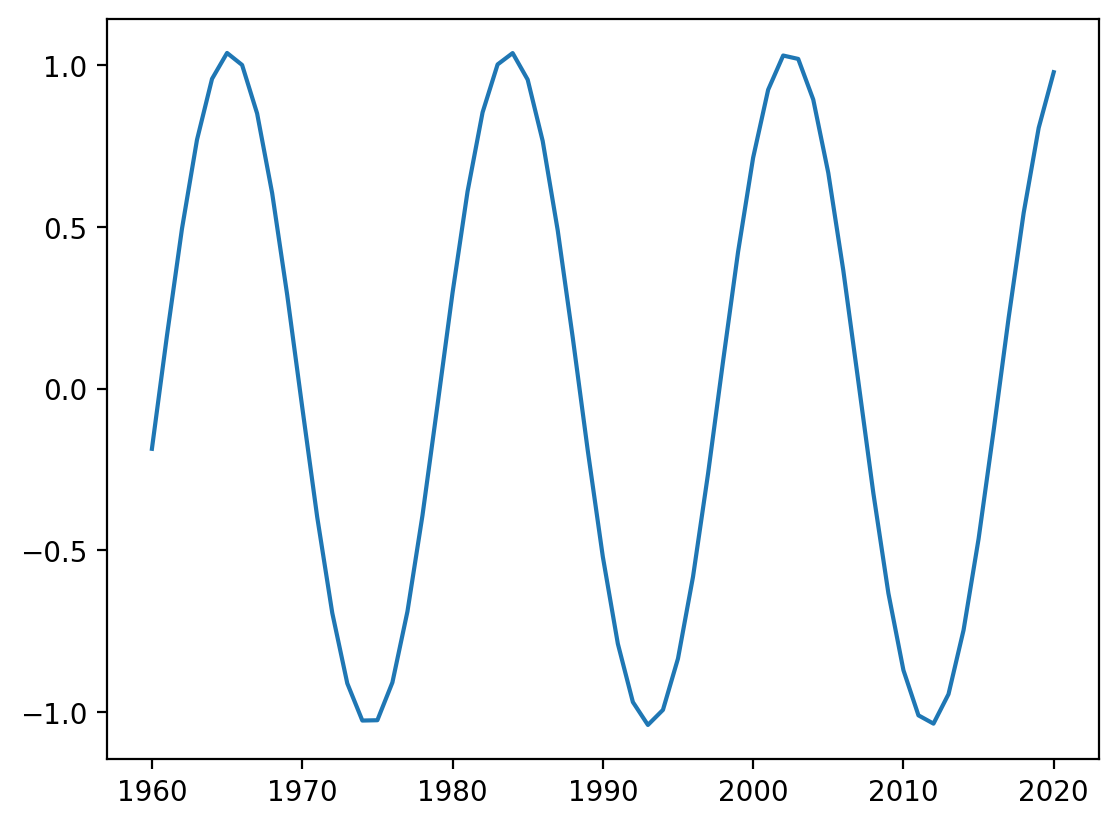

In [20]:
plt.plot(steric)

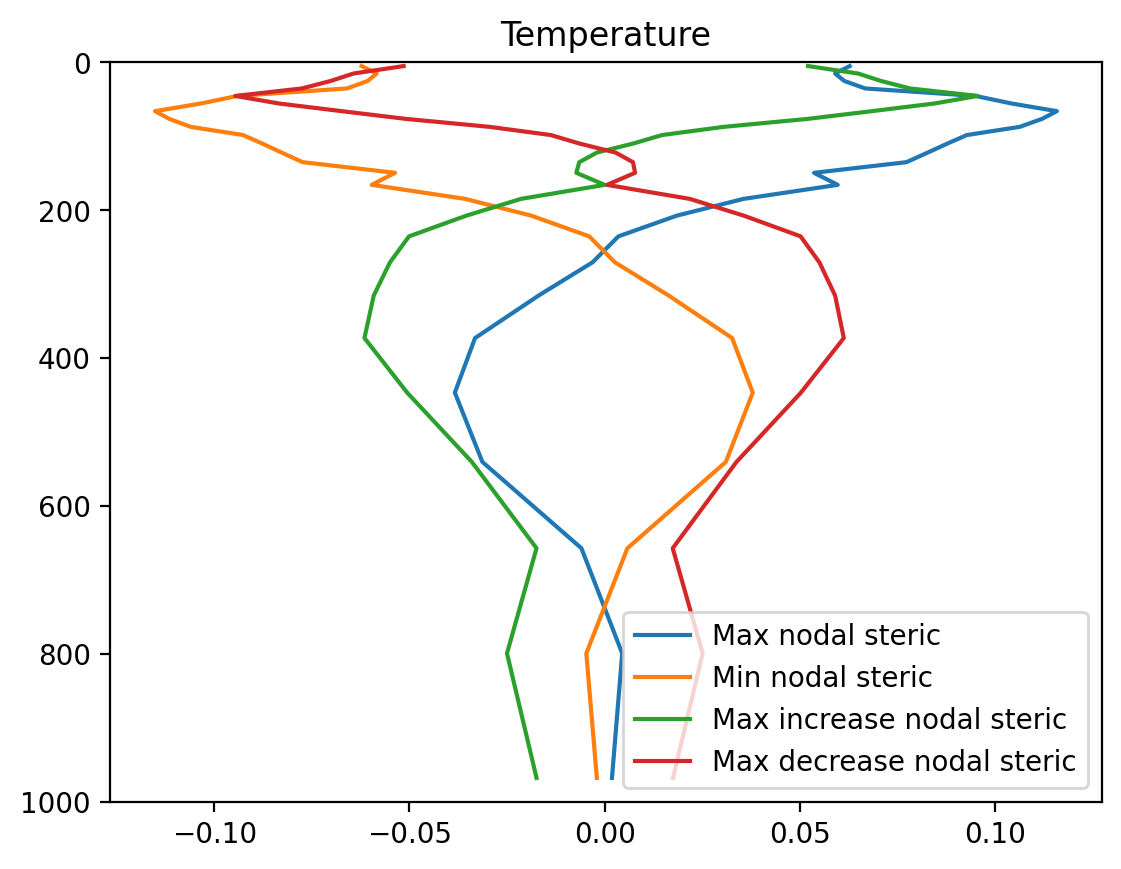

In [21]:
for i in range(4):
    plt.plot(prof[i,:],sumtemp2['depth']);
plt.gca().invert_yaxis();
plt.ylim([1000,0]);
plt.title('Temperature')
plt.legend(['Max nodal steric','Min nodal steric','Max increase nodal steric','Max decrease nodal steric']);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/profiles_EN4_temperature.pdf', dpi=150)

In [25]:
mask = slc.steric_masks_north_sea(mean_sal, 'EBB')
SumTemp = (mean_sal * mask).mean(dim=['lat', 'lon'])

sumtemp2 = SumTemp[:,0:26]
t = sumtemp2.time

nodal = np.zeros((len(t),26))

for i in range(26):
    reg_df = sumtemp2[:,i].to_dataframe()
    del reg_df['depth']

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    #del reg_df['lat']
    #del reg_df['lon']
    
    reg_df.columns = ['Steric','nod1','nod2']

    res_nr, res_full_nr = compute_model(reg_df)

    res_nr['total'] = res_nr['total'] - res_nr['trend']
    nodal[:,i] = res_nr['total']

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_li

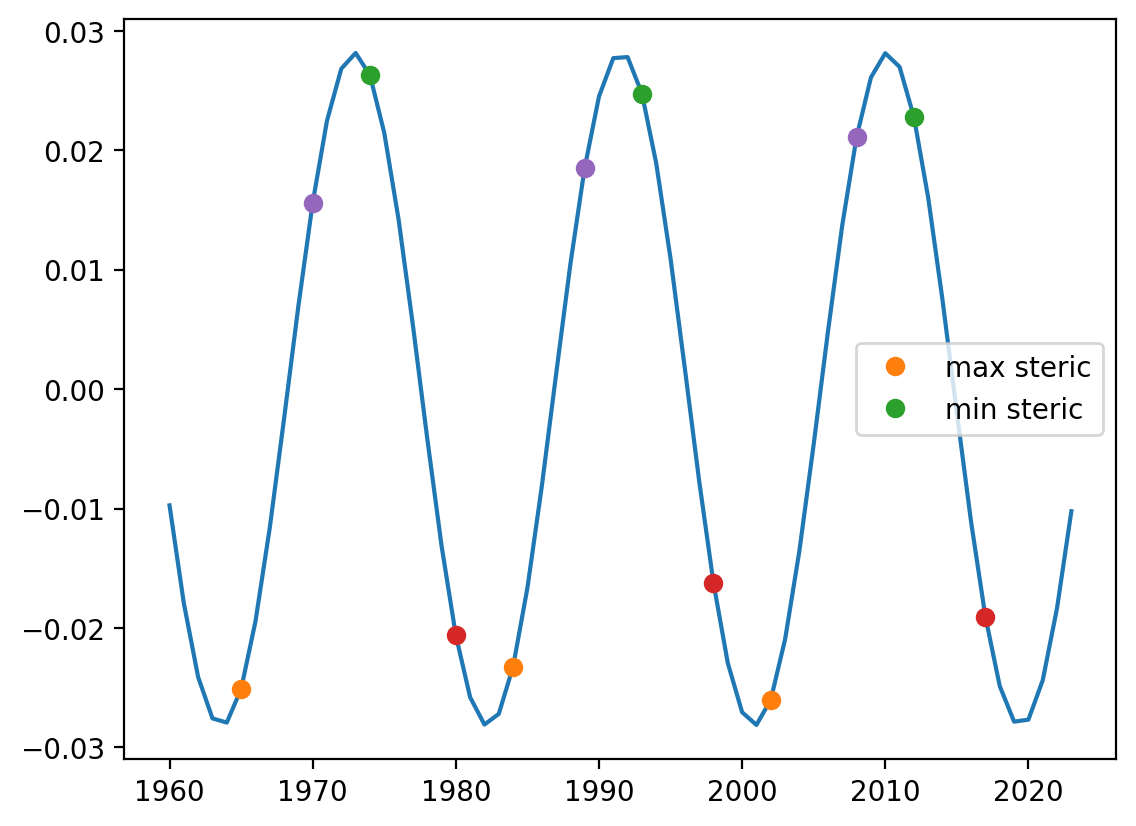

In [26]:
import scipy as sc

steric = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/nodal_steric.csv',index_col=0)
steric = steric.loc[1960:2020]

prof = np.zeros((4,26))

for i in range(26):
    der = steric.diff()

    peaks, _ = sc.signal.find_peaks(steric.values.flatten())
    troughs, _ = sc.signal.find_peaks(-steric.values.flatten())
    diff_max, _ = sc.signal.find_peaks(der.values.flatten())
    diff_min, _ = sc.signal.find_peaks(-der.values.flatten())
        
    prof[0,i] = nodal[peaks,i].mean()    
    prof[1,i] = nodal[troughs,i].mean() 
    prof[2,i] = nodal[diff_max,i].mean() 
    prof[3,i] = nodal[diff_min,i].mean() 

plt.plot(t,nodal[:,0]);
plt.plot(t[peaks],nodal[peaks,0],'o',label='max steric');
plt.plot(t[troughs],nodal[troughs,0],'o',label='min steric');
plt.plot(t[diff_max],nodal[diff_max,0],'o');
plt.plot(t[diff_min],nodal[diff_min,0],'o');
plt.legend()

In [27]:
prof_df = pd.DataFrame(prof)

prof_df.to_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/sal_data.csv')

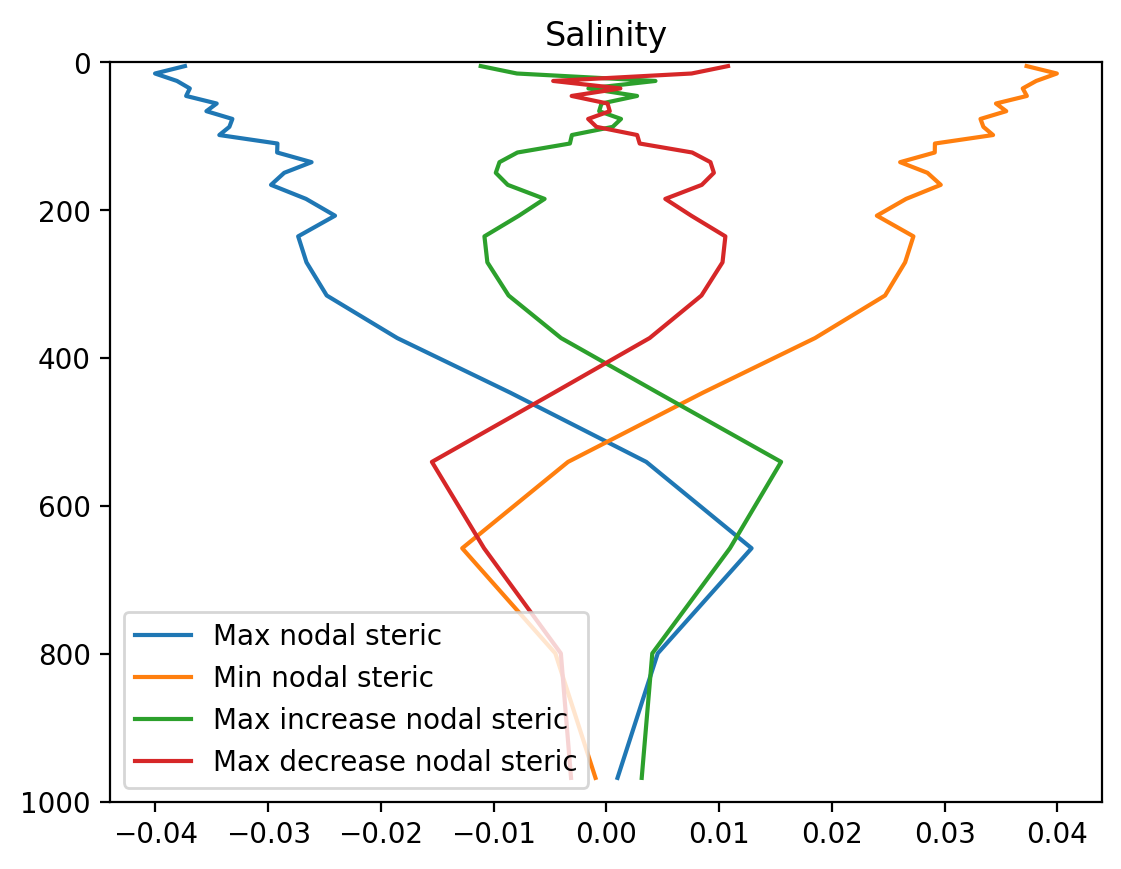

In [65]:
for i in range(4):
    plt.plot(prof[i,:],sumtemp2['depth']);
plt.gca().invert_yaxis();
plt.ylim([1000,0]);
plt.title('Salinity')
plt.legend(['Max nodal steric','Min nodal steric','Max increase nodal steric','Max decrease nodal steric']);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/profiles_EN4_salinity.pdf', dpi=150)

In [66]:
reg_df

,Steric,nod1,nod2
time,,,
1960,35.875116,1.000000,0.000000
1961,35.818114,0.943562,0.331195
1962,35.901962,0.780620,0.625006
1963,35.904135,0.529565,0.848270
1964,35.933880,0.218735,0.975784
...,...,...,...
2019,35.881853,0.482703,0.875784
2020,35.873344,0.165405,0.986226
2021,35.870710,-0.170563,0.985347


In [69]:
res_nr, res_full_nr = compute_model(reg_df)

In [70]:
print(res_nr)

          nod1      nod2      trend      total  nodal_steric
time                                                        
1960  0.002838  0.000000  35.884678  35.887516      0.002838
1961  0.002678  0.000460  35.886921  35.890060      0.003139
1962  0.002216  0.000869  35.889162  35.892246      0.003084
1963  0.001503  0.001179  35.891392  35.894074      0.002682
1964  0.000621  0.001356  35.893607  35.895584      0.001977
...        ...       ...        ...        ...           ...
2019  0.001370  0.001217  35.900423  35.903010      0.002587
2020  0.000469  0.001371  35.898709  35.900549      0.001840
2021 -0.000484  0.001370  35.897010  35.897895      0.000885
2022 -0.001383  0.001214  35.895321  35.895151     -0.000169
2023 -0.002126  0.000921  35.893635  35.892430     -0.001205

[64 rows x 5 columns]


<AxesSubplot:xlabel='time'>

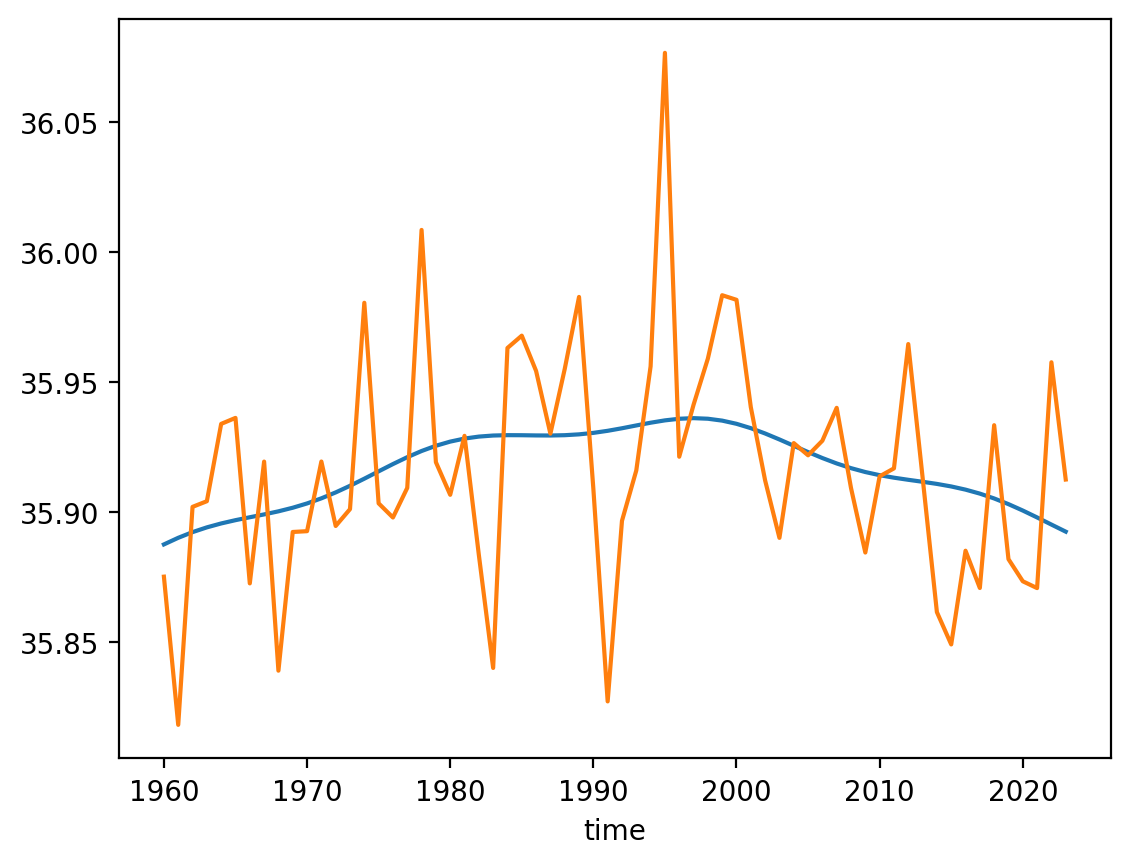

In [71]:
res_nr['total'].plot();
reg_df['Steric'].plot()
#mean_sal[:,0,25,1].plot();

In [230]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(mean_temp[:,0,25,1], res_nr['total'])
RMSE = math.sqrt(MSE)

In [231]:
print(RMSE)

0.7419589728027118


In [232]:
from scipy.stats import chisquare

stats = chisquare(mean_temp[:,0,25,1],res_nr['total']);

In [233]:
print(stats)

Power_divergenceResult(statistic=0.1259714957178969, pvalue=1.0)
